# EXERCÍCIO 2 DE MICROECONOMETRIA APLICADA

## Importação das bibliotecas

In [68]:
# Análise de dados básica

import pandas as pd
import numpy as np

# Visualização

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import openpyxl
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Econometria

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from linearmodels.iv import IV2SLS
from linearmodels.panel import compare  
from statsmodels.stats.stattools import durbin_watson 
from linearmodels.panel import PanelOLS
import linearmodels.panel as pl
from linearmodels import PanelOLS, RandomEffects
from linearmodels.panel import compare, PooledOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Estatística

from scipy import stats

## Configuração do display

In [69]:
# O pandas foi configurado para mostrar todas as colunas e as 100 primeiras linhas

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 10) 

## Carregamento da base de dados

In [70]:
# O arquivo CSV foi transformado em um dataframe

df = pd.read_excel("vigitel_acumulada.xlsx")
display(df)

,ano,cidade,q6,q7,q8_anos,q36,q47,q61,q69,civil
0,2021,5,18,1,9,NaN,1,NaN,1,1
1,2022,20,23,1,9,NaN,1,NaN,1,3
2,2021,4,31,1,5,NaN,1,NaN,1,3
3,2021,2,40,1,7,NaN,1,NaN,1,1
4,2021,16,21,1,5,3.0,2,30.0,1,2
...,...,...,...,...,...,...,...,...,...,...
159003,2018,7,71,1,16,NaN,2,NaN,1,5
159004,2018,8,74,1,16,2.0,1,NaN,1,2
159005,2018,17,83,1,16,NaN,2,NaN,1,2
159006,2018,17,73,1,17,NaN,2,NaN,2,2


## Estatísticas descritivas (pré tratamento)

In [71]:
# Para incluir colunas categóricas/object também
estatisticas_completas = df.describe(include='all')
print(estatisticas_completas)

                 ano         cidade             q6             q7  \
count  159008.000000  159008.000000  159008.000000  159008.000000   
mean     2019.218203      14.105127      53.998554       1.645169   
std         1.147609       7.834059      18.344195       0.478464   
min      2018.000000       1.000000      18.000000       1.000000   
25%      2018.000000       7.000000      40.000000       1.000000   
50%      2019.000000      14.000000      56.000000       2.000000   
75%      2020.000000      21.000000      68.000000       2.000000   
max      2022.000000      27.000000     107.000000       2.000000   

             q8_anos           q36            q47          q61            q69  \
count  159008.000000  55831.000000  159008.000000  8775.000000  159008.000000   
mean       11.098404      2.869356       1.497434    56.189858      15.578927   
std         5.122568      2.105200       0.499995   190.169907      79.644557   
min         0.000000      1.000000       1.000000     

## Tratamento da base

In [72]:
# Renomear múltiplas colunas
df = df.rename(columns={
    'q6': 'idade',
    'q7': 'sexo',
    'q36': 'alcool_frequencia',
    'q47': 'trabalha',
    'q61': 'cigarro_frequencia',
    'q69': 'cor',
    'civil': 'estado_civil',
    'q8_anos': 'anos_estudos'
})

# Substituir missing na coluna cigarro_frequencia por 0
df['cigarro_frequencia'] = df['cigarro_frequencia'].fillna(0)

# Substituir missing na coluna alcool_frequencia por 0
df['alcool_frequencia'] = df['alcool_frequencia'].fillna(0)

# Dummy da covid
df['covid'] = ((df['ano'] == 2020) | (df['ano'] == 2021)).astype(int)

# Variável para idade 18-25 anos
df['idade_18_25'] = ((df['idade'] >= 18) & (df['idade'] <= 25)).astype(int)

# Variável para idade 26-40 anos
df['idade_26_40'] = ((df['idade'] >= 26) & (df['idade'] <= 40)).astype(int)

# Variável para idade 41-60 anos
df['idade_41_60'] = ((df['idade'] >= 41) & (df['idade'] <= 60)).astype(int)

# Variável para idade fora dos intervalos (outliers)
df['idade_61_mais'] = ((df['idade'] < 18) | (df['idade'] > 60)).astype(int)

# Variável para sexo masculino (q7 == 1)
df['sexo_masculino'] = (df['sexo'] == 1).astype(int)

# Criar a variável alcool: 1 se alcool_frequencia >= 1, 0 caso contrário
df['alcool'] = (df['alcool_frequencia'] >= 1).astype(int)

# Variável para trabalha (q47 == 1)
df['trabalhador'] = (df['trabalha'] == 1).astype(int)

# Variável para cigarro (q61 >= 1)
df['cigarro'] = (df['cigarro_frequencia'] >= 1).astype(int)

# Variável para cor (q69 == 1)
df['cor_branco'] = (df['cor'] == 1).astype(int)

# Método mais limpo usando isin()
df['uniao_estavel'] = df['estado_civil'].isin([2, 3]).astype(int)

# Filtrar observações com cigarro_frequencia > 84
df = df[df['cigarro_frequencia'] <= 500]

# Filtrar observações com cor != 888 e cor != 777 e estado_civil != 888
df = df[(df['cor'] != 888) & (df['cor'] != 777) & (df['cor'] != 80) & (df['estado_civil'] != 888)]

# Primeiro, vamos mapear cada cidade para sua região
mapeamento_regioes = {
    # Região SUL
    7: 'sul',   # curitiba (PR)
    8: 'sul',   # florianopolis (SC) 
    17: 'sul',  # porto alegre (RS)
    
    # Região SUDESTE
    3: 'sudeste',   # belo horizonte (MG)
    21: 'sudeste',  # rio de janeiro (RJ)
    24: 'sudeste',  # sao paulo (SP)
    26: 'sudeste',  # vitoria (ES)
    
    # Região NORDESTE
    1: 'nordeste',   # aracaju (SE)
    9: 'nordeste',   # fortaleza (CE)
    11: 'nordeste',  # joao pessoa (PB)
    13: 'nordeste',  # maceio (AL)
    15: 'nordeste',  # natal (RN)
    19: 'nordeste',  # recife (PE)
    22: 'nordeste',  # salvador (BA)
    23: 'nordeste',  # sao luis (MA)
    25: 'nordeste',  # teresina (PI)
    
    # Região NORTE
    2: 'norte',   # belem (PA)
    4: 'norte',   # boa vista (RR)
    12: 'norte',  # macapa (AP)
    14: 'norte',  # manaus (AM)
    18: 'norte',  # porto velho (RO)
    20: 'norte',  # rio branco (AC)
    
    # Região CENTRO-OESTE
    5: 'centro_oeste',  # campo grande (MS)
    6: 'centro_oeste',  # cuiaba (MT)
    10: 'centro_oeste', # goiania (GO)
    16: 'centro_oeste', # palmas (TO)
    27: 'centro_oeste'  # distrito federal (DF)
}

# Criar a coluna de região
df['regiao'] = df['cidade'].map(mapeamento_regioes)

# Agora criar as dummies para cada região
regioes = ['sul', 'sudeste', 'nordeste', 'norte', 'centro_oeste']

for regiao in regioes:
    df[f'regiao_{regiao}'] = (df['regiao'] == regiao).astype(int)

df

,ano,cidade,idade,sexo,anos_estudos,alcool_frequencia,trabalha,cigarro_frequencia,cor,estado_civil,covid,idade_18_25,idade_26_40,idade_41_60,idade_61_mais,sexo_masculino,alcool,trabalhador,cigarro,cor_branco,uniao_estavel,regiao,regiao_sul,regiao_sudeste,regiao_nordeste,regiao_norte,regiao_centro_oeste
0,2021,5,18,1,9,0.0,1,0.0,1,1,1,1,0,0,0,1,0,1,0,1,0,centro_oeste,0,0,0,0,1
1,2022,20,23,1,9,0.0,1,0.0,1,3,0,1,0,0,0,1,0,1,0,1,1,norte,0,0,0,1,0
2,2021,4,31,1,5,0.0,1,0.0,1,3,1,0,1,0,0,1,0,1,0,1,1,norte,0,0,0,1,0
3,2021,2,40,1,7,0.0,1,0.0,1,1,1,0,1,0,0,1,0,1,0,1,0,norte,0,0,0,1,0
4,2021,16,21,1,5,3.0,2,30.0,1,2,1,1,0,0,0,1,1,0,1,1,1,centro_oeste,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159003,2018,7,71,1,16,0.0,2,0.0,1,5,0,0,0,0,1,1,0,0,0,1,0,sul,1,0,0,0,0
159004,2018,8,74,1,16,2.0,1,0.0,1,2,0,0,0,0,1,1,1,1,0,1,1,sul,1,0,0,0,0
159005,2018,17,83,1,16,0.0,2,0.0,1,2,0,0,0,0,1,1,0,0,0,1,1,sul,1,0,0,0,0
159006,2018,17,73,1,17,0.0,2,0.0,2,2,0,0,0,0,1,1,0,0,0,0,1,sul,1,0,0,0,0


## Estatísticas descritivas (pós tratamento)

In [73]:
# Para incluir colunas categóricas/object também
estatisticas_completas = df.describe(include='all')
print(estatisticas_completas)

                  ano         cidade          idade           sexo  \
count   145434.000000  145434.000000  145434.000000  145434.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean      2019.231301      14.114471      53.074508       1.640896   
...               ...            ...            ...            ...   
min       2018.000000       1.000000      18.000000       1.000000   
25%       2018.000000       7.000000      39.000000       1.000000   
50%       2019.000000      14.000000      55.000000       2.000000   
75%       2020.000000      21.000000      67.000000       2.000000   
max       2022.000000      27.000000     107.000000       2.000000   

         anos_estudos  alcool_frequencia       trabalha  cigarro_frequencia  \
count   145434.000000      145434.000000  145434.000000       145434.000000   
u

## Análise exploratória

### Densidade Kernel

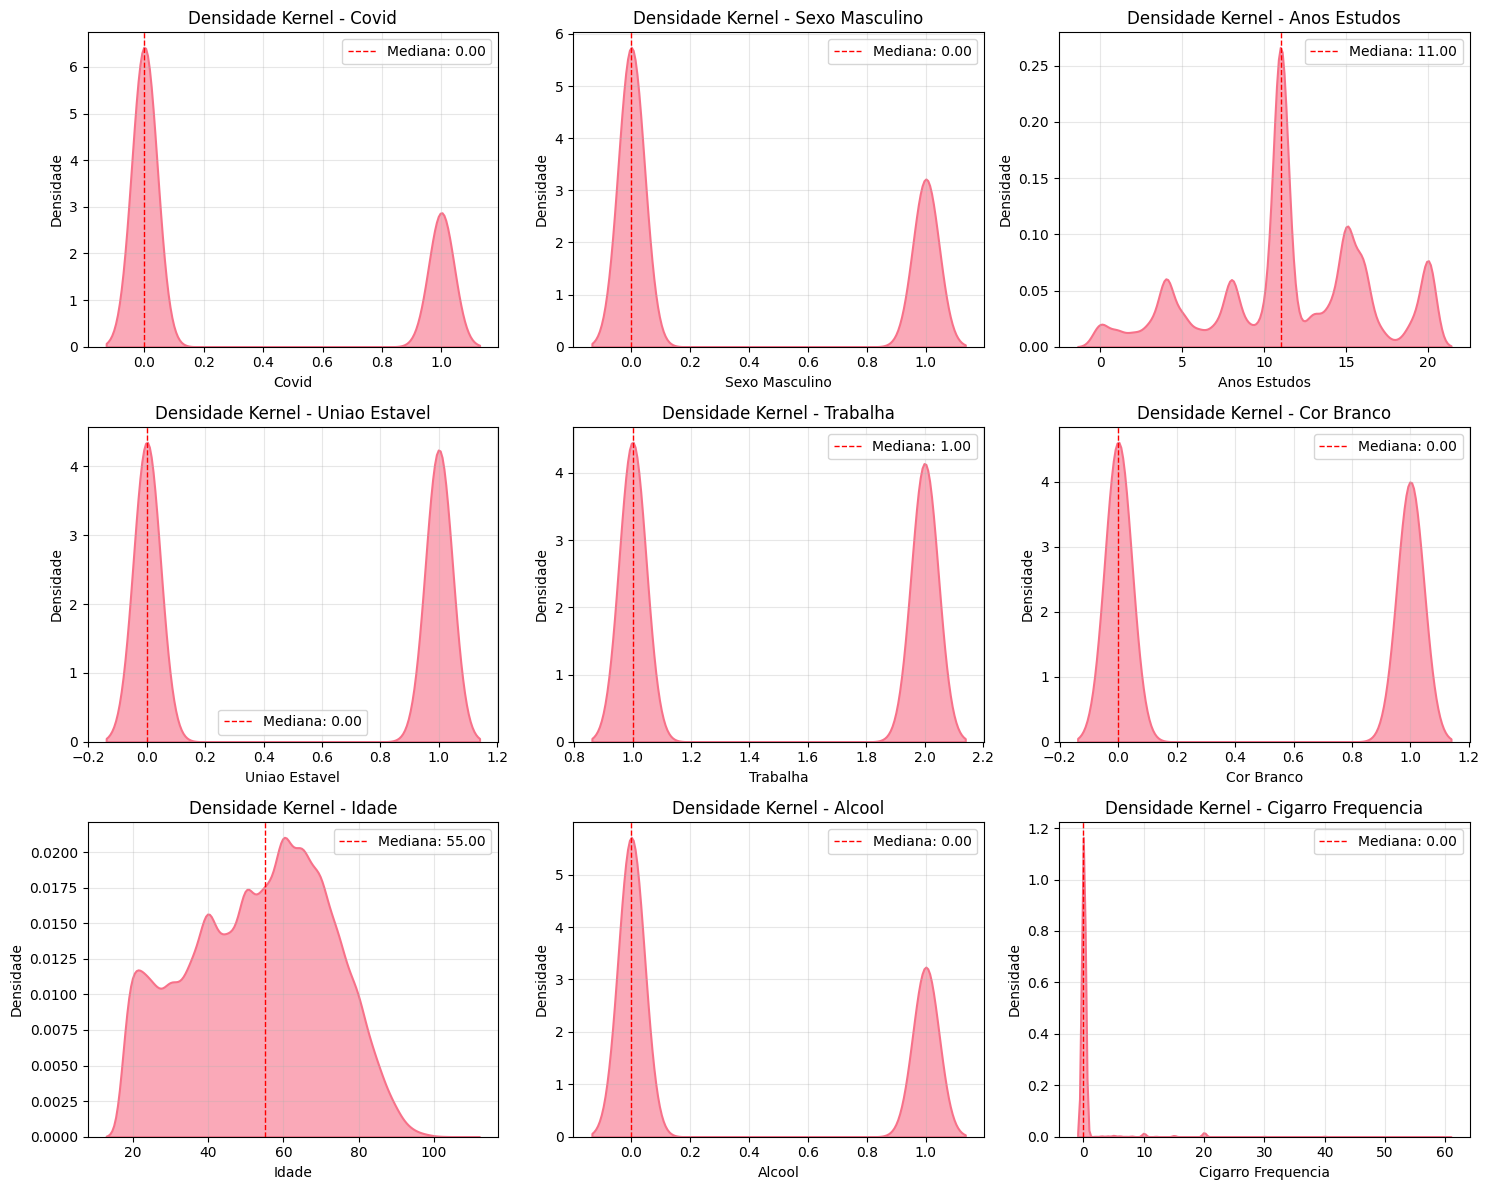


GRÁFICOS INDIVIDUAIS DE DENSIDADE KERNEL - VARIÁVEIS NUMÉRICAS


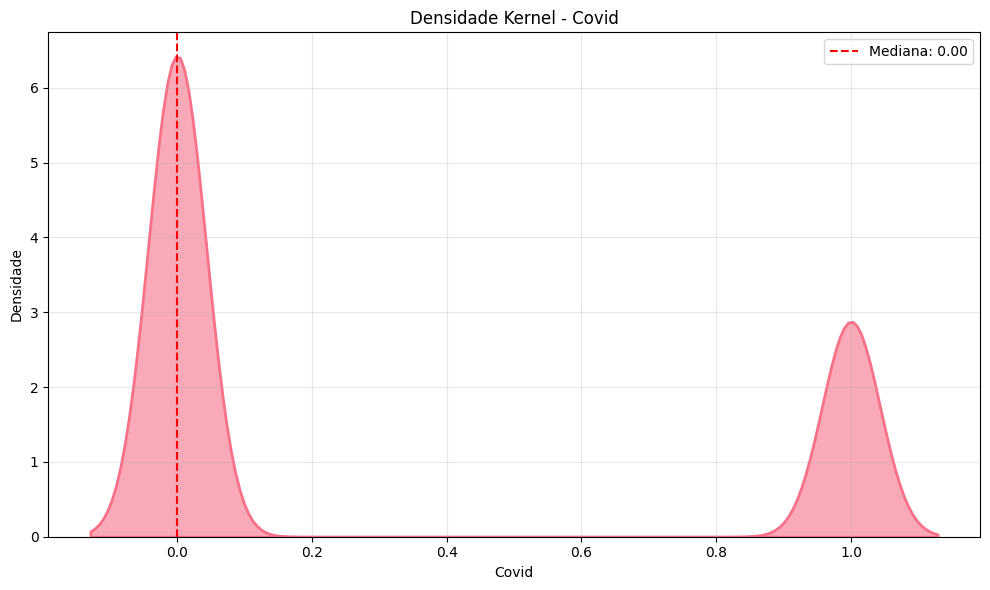

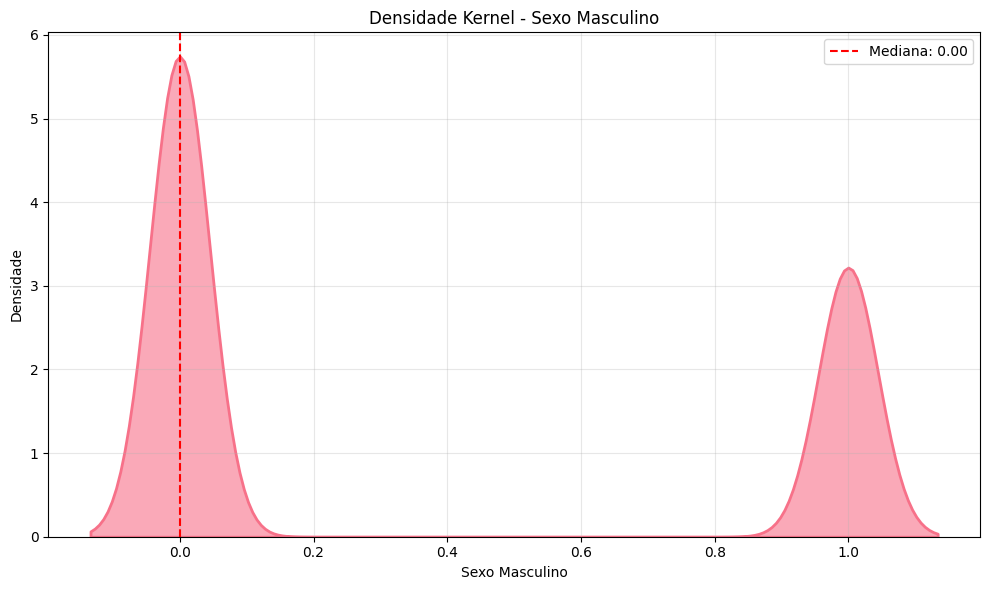

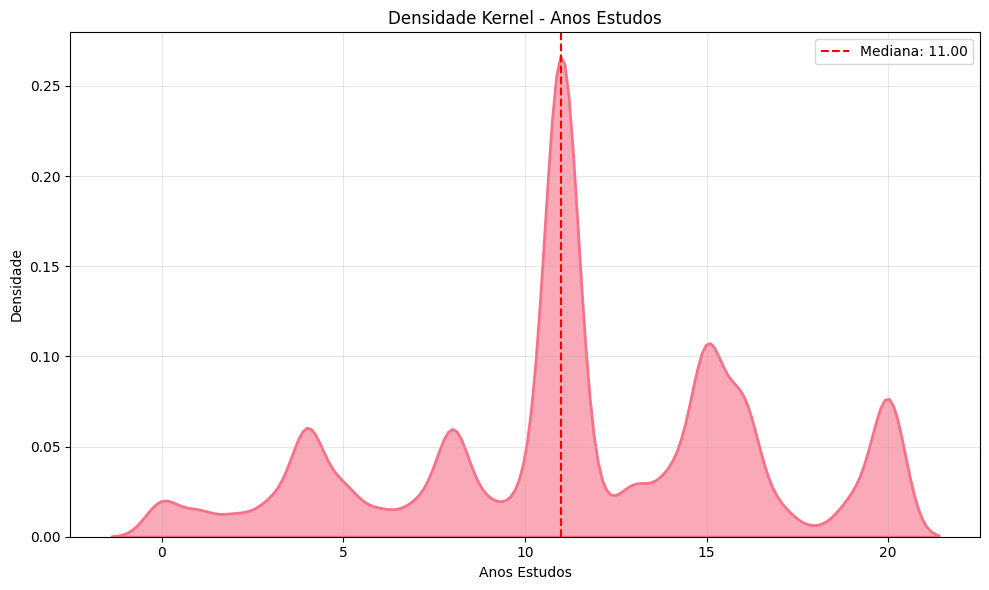

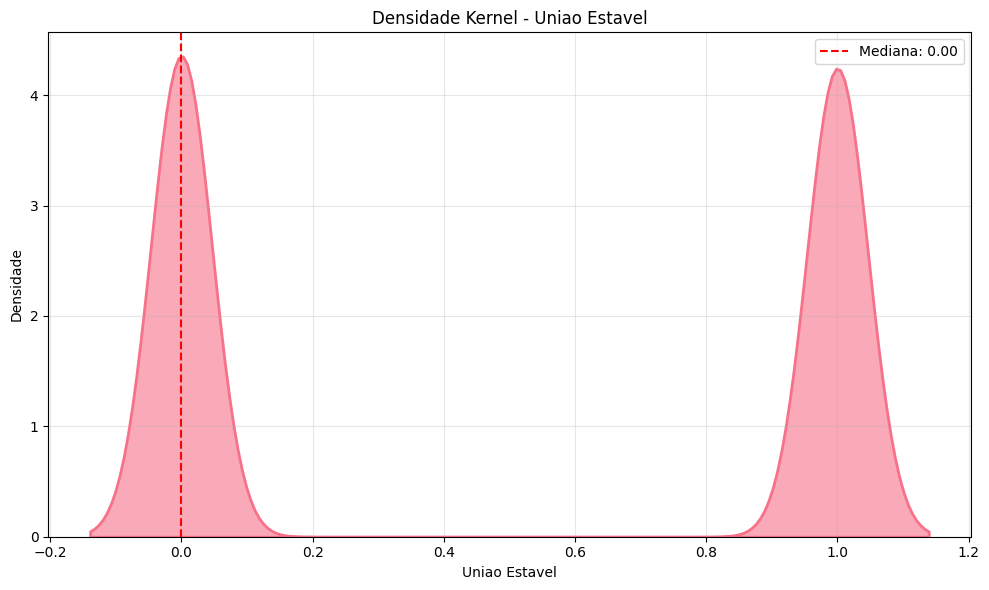

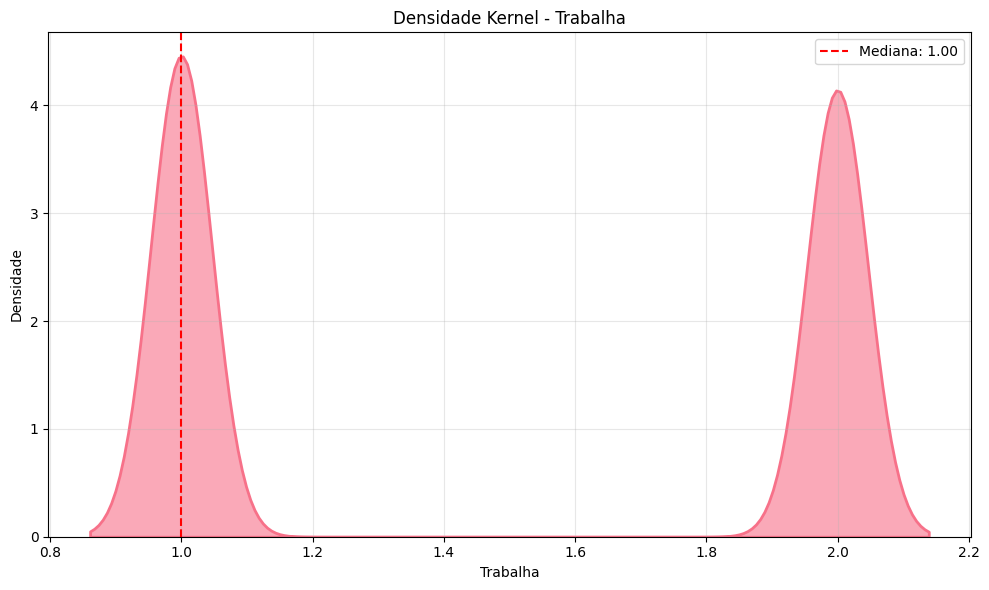

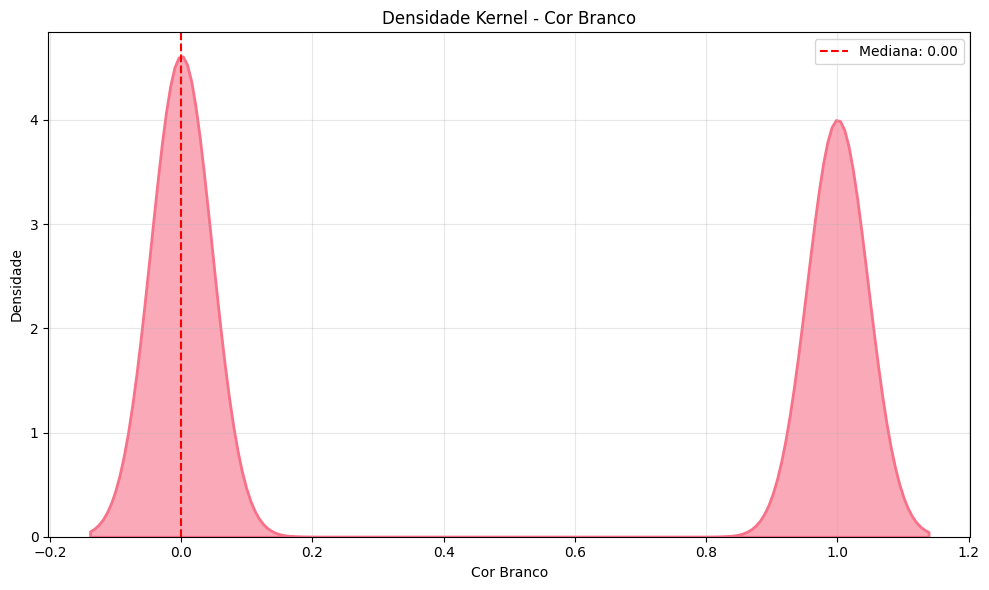

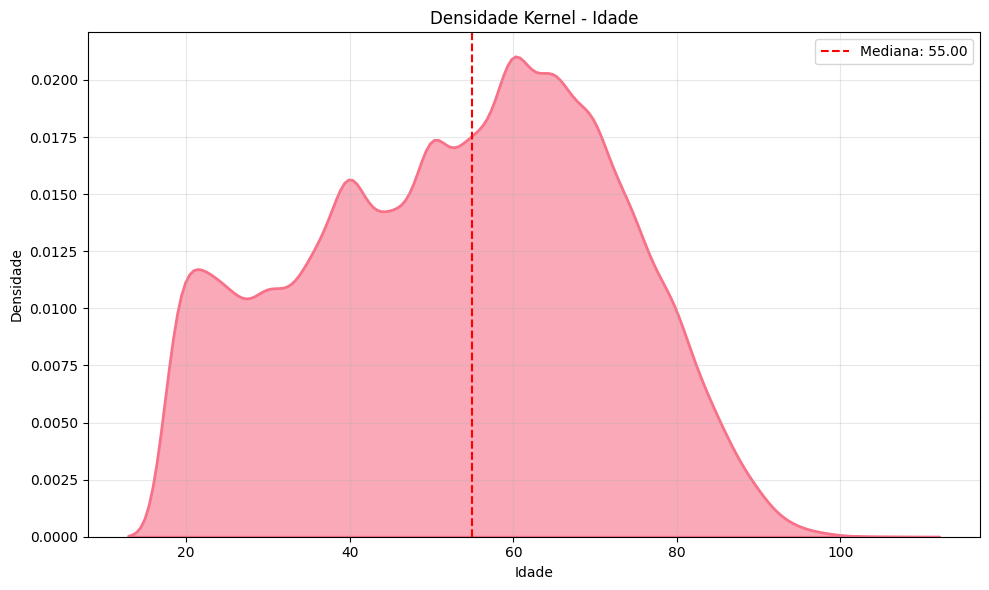

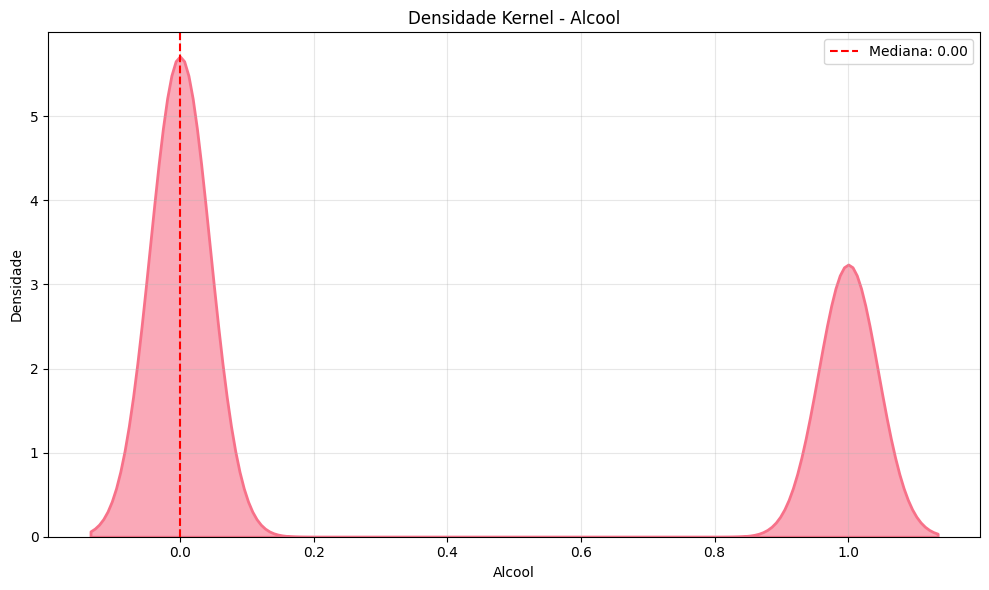

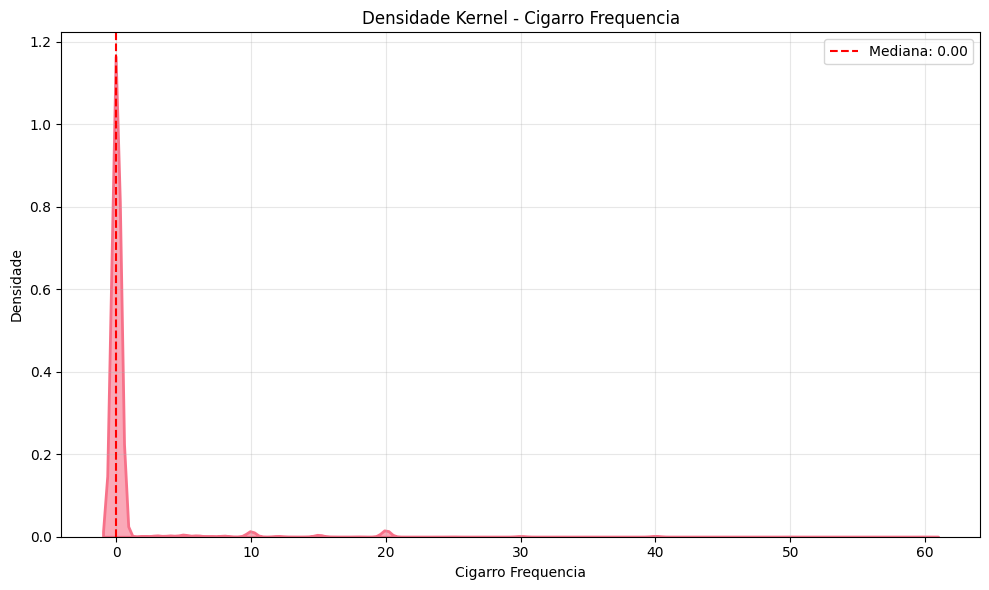


GRÁFICOS DE BARRAS - VARIÁVEIS CATEGÓRICAS


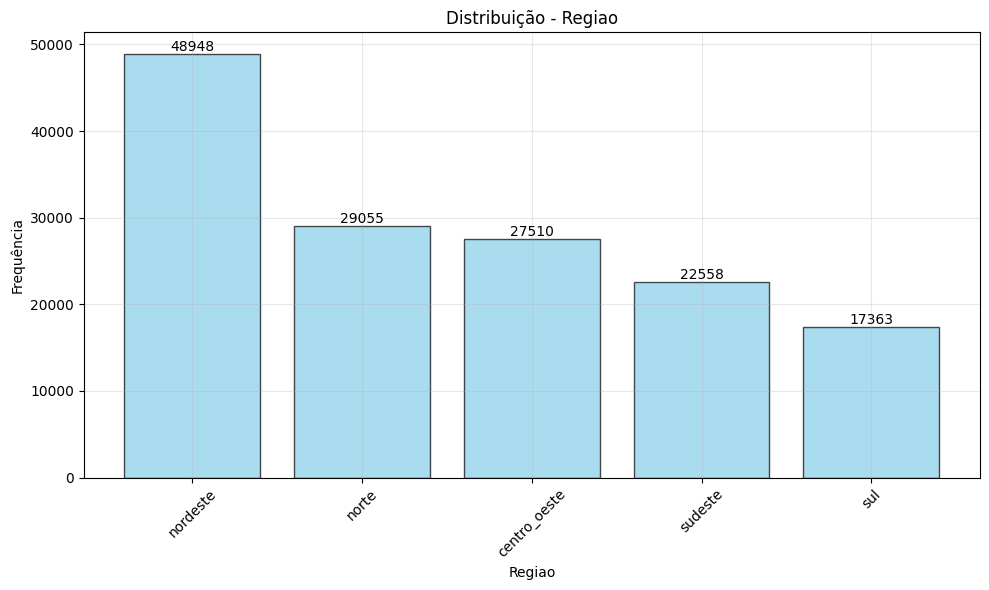


Tabela de frequência - regiao:
   Categoria  Frequência  Porcentagem
    nordeste       48948        33.66
       norte       29055        19.98
centro_oeste       27510        18.92
     sudeste       22558        15.51
         sul       17363        11.94



In [74]:
# Configuração do estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

# Lista de variáveis para plotar - separando numéricas e categóricas
variaveis_numericas = ['covid', 'sexo_masculino', 'anos_estudos', 'uniao_estavel', 
                      'trabalha', 'cor_branco', 'idade', 'alcool', 'cigarro_frequencia']
variaveis_categoricas = ['regiao']

# Criar os gráficos em subplots apenas para variáveis numéricas
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, var in enumerate(variaveis_numericas):
    if i < len(axes):
        # Usar dados reais do DataFrame df
        data = df[var].dropna()
        
        # Plotar densidade kernel apenas para variáveis numéricas
        sns.kdeplot(data, ax=axes[i], fill=True, alpha=0.6, linewidth=1.5)
        
        # Adicionar linha da mediana
        mediana = np.median(data)
        axes[i].axvline(mediana, color='red', linestyle='--', linewidth=1, 
                       label=f'Mediana: {mediana:.2f}')
        
        # Configurações do gráfico
        axes[i].set_title(f'Densidade Kernel - {var.replace("_", " ").title()}')
        axes[i].set_xlabel(var.replace("_", " ").title())
        axes[i].set_ylabel('Densidade')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# Remover eixos vazios se houver
for i in range(len(variaveis_numericas), len(axes)):
    axes[i].set_visible(False)

# Ajustar layout
plt.tight_layout()
plt.show()

# Gráficos individuais para variáveis numéricas
print("\n" + "="*60)
print("GRÁFICOS INDIVIDUAIS DE DENSIDADE KERNEL - VARIÁVEIS NUMÉRICAS")
print("="*60)

for var in variaveis_numericas:
    plt.figure(figsize=(10, 6))
    
    # Usar dados reais do DataFrame df
    data = df[var].dropna()
    
    # Plot
    sns.kdeplot(data, fill=True, alpha=0.6, linewidth=2)
    mediana = np.median(data)
    plt.axvline(mediana, color='red', linestyle='--', linewidth=1.5, 
                label=f'Mediana: {mediana:.2f}')
    
    plt.title(f'Densidade Kernel - {var.replace("_", " ").title()}')
    plt.xlabel(var.replace("_", " ").title())
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Gráficos para variáveis categóricas (gráficos de barras)
print("\n" + "="*60)
print("GRÁFICOS DE BARRAS - VARIÁVEIS CATEGÓRICAS")
print("="*60)

for var in variaveis_categoricas:
    plt.figure(figsize=(10, 6))
    
    # Contar frequências
    contagem = df[var].value_counts()
    
    # Plotar gráfico de barras
    bars = plt.bar(contagem.index, contagem.values, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Adicionar valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.title(f'Distribuição - {var.replace("_", " ").title()}')
    plt.xlabel(var.replace("_", " ").title())
    plt.ylabel('Frequência')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabela de frequência
    print(f"\nTabela de frequência - {var}:")
    freq_table = pd.DataFrame({
        'Categoria': contagem.index,
        'Frequência': contagem.values,
        'Porcentagem': (contagem.values / len(df) * 100).round(2)
    })
    print(freq_table.to_string(index=False))
    print()

### Estatísticas descritivas das variáveis utilizadas nos modelos

In [75]:
# Lista de variáveis
variaveis = ['covid', 'sexo_masculino', 'anos_estudos', 'uniao_estavel', 
             'trabalha', 'cor_branco', 'idade', 'alcool', 'cigarro_frequencia']

# Estatísticas descritivas básicas
print("=" * 80)
print("ESTATÍSTICAS DESCRITIVAS - RESUMO GERAL")
print("=" * 80)

descricao = df[variaveis].describe().T
descricao['variancia'] = df[variaveis].var()
descricao['coef_variacao'] = (df[variaveis].std() / df[variaveis].mean() * 100).round(2)
descricao['n_missing'] = df[variaveis].isnull().sum()
descricao['pct_missing'] = (df[variaveis].isnull().sum() / len(df) * 100).round(2)

print(descricao[['count', 'mean', 'std', 'variancia', 'min', '25%', '50%', '75%', 'max', 
                 'coef_variacao', 'n_missing', 'pct_missing']])

ESTATÍSTICAS DESCRITIVAS - RESUMO GERAL
                       count       mean        std   variancia   min   25%  \
covid               145434.0   0.309109   0.462128    0.213562   0.0   0.0   
sexo_masculino      145434.0   0.359104   0.479740    0.230150   0.0   0.0   
anos_estudos        145434.0  11.424777   4.989361   24.893728   0.0   8.0   
uniao_estavel       145434.0   0.493495   0.499959    0.249959   0.0   0.0   
trabalha            145434.0   1.481607   0.499663    0.249663   1.0   1.0   
cor_branco          145434.0   0.464499   0.498740    0.248741   0.0   0.0   
idade               145434.0  53.074508  18.306006  335.109862  18.0  39.0   
alcool              145434.0   0.361697   0.480493    0.230874   0.0   0.0   
cigarro_frequencia  145434.0   0.671225   3.480281   12.112359   0.0   0.0   

                     50%   75%    max  coef_variacao  n_missing  pct_missing  
covid                0.0   1.0    1.0         149.50          0          0.0  
sexo_masculino       

## Estimação do Logit e Probit

### Logit binomial

In [76]:
# Preparar as variáveis para o modelo
# Variável dependente
y = df['alcool']

# Variáveis independentes (explicativas)
X = df[['covid', 'sexo_masculino', 'anos_estudos', 'uniao_estavel', 
        'trabalha', 'cor_branco', 'idade_26_40', 'idade_41_60', 'idade_61_mais', 'regiao_sudeste', 'regiao_nordeste', 'regiao_norte', 'regiao_centro_oeste']]

# Adicionar constante (intercepto) ao modelo
X = sm.add_constant(X)

# Estimar o modelo logit
modelo_logit = sm.Logit(y, X).fit(cov_type='HC3')

# Exibir os resultados
print("=" * 80)
print("RESULTADOS DO MODELO LOGIT")
print("=" * 80)
print(modelo_logit.summary())

# Calcular efeitos marginais do Logit
print("\n" + "=" * 80)
print("EFEITOS MARGINAIS DO MODELO LOGIT")
print("=" * 80)

marginal_effects_logit = modelo_logit.get_margeff()
print(marginal_effects_logit.summary())



Optimization terminated successfully.
         Current function value: 0.595145
         Iterations 5
RESULTADOS DO MODELO LOGIT
                           Logit Regression Results                           
Dep. Variable:                 alcool   No. Observations:               145434
Model:                          Logit   Df Residuals:                   145420
Method:                           MLE   Df Model:                           13
Date:                sex, 17 out 2025   Pseudo R-squ.:                 0.09053
Time:                        16:39:49   Log-Likelihood:                -86554.
converged:                       True   LL-Null:                       -95170.
Covariance Type:                  HC3   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7780      0.038    -20.669      0.000

### Probit

In [77]:
# Preparar as variáveis para o modelo
# Variável dependente
y = df['alcool']

# Variáveis independentes (explicativas)
X = df[['covid', 'sexo_masculino', 'anos_estudos', 'uniao_estavel', 
        'trabalha', 'cor_branco', 'idade_26_40', 'idade_41_60', 'idade_61_mais', 'regiao_sudeste', 'regiao_nordeste', 'regiao_norte', 'regiao_centro_oeste']]

# Adicionar constante (intercepto) ao modelo
X = sm.add_constant(X)

# Estimar o modelo probit
modelo_probit = sm.Probit(y, X).fit(cov_type='HC3')

# Exibir os resultados
print("=" * 80)
print("RESULTADOS DO MODELO PROBIT")
print("=" * 80)
print(modelo_probit.summary())

# Adicional: Comparação com Logit (opcional)
print("\n" + "=" * 80)
print("COMPARAÇÃO ENTRE PROBIT E LOGIT")
print("=" * 80)

# Calcular efeitos marginais para interpretação mais intuitiva
marginal_effects = modelo_probit.get_margeff()
print("\nEFEITOS MARGINAIS DO PROBIT (dy/dx):")
print(marginal_effects.summary())

# Comparação de qualidade do ajuste
print(f"\nMÉTRICAS DE QUALIDADE DO AJUSTE:")
print(f"AIC (Probit): {modelo_probit.aic:.4f}")
print(f"BIC (Probit): {modelo_probit.bic:.4f}")
print(f"Log-Likelihood (Probit): {modelo_probit.llf:.4f}")
print(f"Pseudo R² (Probit): {modelo_probit.prsquared:.4f}")

# Para comparação, vamos estimar também o Logit rapidamente
modelo_logit_comparacao = sm.Logit(y, X).fit(cov_type='HC3', disp=0)
print(f"\nAIC (Logit): {modelo_logit_comparacao.aic:.4f}")
print(f"BIC (Logit): {modelo_logit_comparacao.bic:.4f}")
print(f"Log-Likelihood (Logit): {modelo_logit_comparacao.llf:.4f}")
print(f"Pseudo R² (Logit): {modelo_logit_comparacao.prsquared:.4f}")

# Verificar qual modelo tem melhor ajuste
if modelo_probit.aic < modelo_logit_comparacao.aic:
    print("\n✅ PROBIT tem melhor ajuste (menor AIC)")
else:
    print("\n✅ LOGIT tem melhor ajuste (menor AIC)")

# Interpretação dos coeficientes significativos
print("\n" + "=" * 80)
print("INTERPRETAÇÃO DOS EFEITOS MARGINAIS SIGNIFICATIVOS (p < 0.05)")
print("=" * 80)

coeficientes = modelo_probit.params
p_values = modelo_probit.pvalues

for var in coeficientes.index:
    if p_values[var] < 0.05 and var != 'const':
        coef = coeficientes[var]
        # Para Probit, os efeitos marginais são mais interpretáveis que os coeficientes
        print(f"• {var}: coeficiente = {coef:.4f} (p = {p_values[var]:.4f})")

Optimization terminated successfully.
         Current function value: 0.594861
         Iterations 5
RESULTADOS DO MODELO PROBIT
                          Probit Regression Results                           
Dep. Variable:                 alcool   No. Observations:               145434
Model:                         Probit   Df Residuals:                   145420
Method:                           MLE   Df Model:                           13
Date:                sex, 17 out 2025   Pseudo R-squ.:                 0.09097
Time:                        16:39:51   Log-Likelihood:                -86513.
converged:                       True   LL-Null:                       -95170.
Covariance Type:                  HC3   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4730      0.023    -20.776      0.00

## Regressão de Poisson

### Estimação

In [78]:
# =============================================================================
# POISSON COM ERROS ROBUSTOS - MODELO ESCOLHIDO
# =============================================================================

print("="*70)
print("POISSON COM ERROS ROBUSTOS - MODELO FINAL")
print("="*70)

# 1. CORREÇÃO DA MULTICOLINEARIDADE (mantém a correção das dummies)
print("\n1. CORREÇÃO DA MULTICOLINEARIDADE")
X_clean_corrigido = df[['covid', 'sexo_masculino', 'anos_estudos', 'uniao_estavel', 
        'trabalha', 'cor_branco', 'idade_26_40', 'idade_41_60', 'idade_61_mais', 'regiao_sudeste', 'regiao_nordeste', 'regiao_norte', 'regiao_centro_oeste']]  
X_clean_corrigido = sm.add_constant(X_clean_corrigido)

y_clean = df['cigarro_frequencia']

print(f"Variáveis no modelo: {X_clean_corrigido.shape[1]}")
print("Categoria de referência para idade: idade_18_24")

# 2. ESTIMAR POISSON COM ERROS ROBUSTOS
print("\n2. POISSON COM ERROS ROBUSTOS (HC0)")
modelo_poisson_robusto_final = sm.Poisson(y_clean, X_clean_corrigido).fit(
    cov_type='HC0',  # Correção para heterocedasticidade
    disp=1, 
    maxiter=100
)

print("✅ Poisson com erros robustos convergiu com sucesso!")
print(modelo_poisson_robusto_final.summary())

# 3. ANÁLISE DE DIAGNÓSTICO DO MODELO ROBUSTO
print("\n" + "="*70)
print("DIAGNÓSTICO DO MODELO POISSON ROBUSTO")
print("="*70)

# Calcular estatísticas de dispersão para referência
y_pred_robusto = modelo_poisson_robusto_final.predict(X_clean_corrigido)
pearson_chi2_robusto = (((y_clean - y_pred_robusto) ** 2) / y_pred_robusto).sum()
ratio_dispersao_robusto = pearson_chi2_robusto / modelo_poisson_robusto_final.df_resid

print(f"Razão de dispersão: {ratio_dispersao_robusto:.4f}")
print(f"Média da variável resposta: {y_clean.mean():.4f}")
print(f"Variância da variável resposta: {y_clean.var():.4f}")
print(f"Razão variância/média: {y_clean.var() / y_clean.mean():.4f}")

if ratio_dispersao_robusto > 1.2:
    print("⚠️  Superdispersão presente, mas erros robustos fornecem inferência válida")
else:
    print("✅ Dispersão adequada")

# 4. INTERPRETAÇÃO DOS COEFICIENTES (IRR)
print("\n" + "="*70)
print("INTERPRETAÇÃO DOS COEFICIENTES - POISSON ROBUSTO (IRR)")
print("="*70)

coeficientes_robusto = modelo_poisson_robusto_final.params
irr_robusto = np.exp(coeficientes_robusto)
conf_int_robusto = np.exp(modelo_poisson_robusto_final.conf_int())

resultados_irr_robusto = pd.DataFrame({
    'Coeficiente': coeficientes_robusto,
    'IRR': irr_robusto,
    'IRR_2.5%': conf_int_robusto[0],
    'IRR_97.5%': conf_int_robusto[1],
    'P>|z|': modelo_poisson_robusto_final.pvalues,
    'Std Err Robust': modelo_poisson_robusto_final.bse
})

print(resultados_irr_robusto.round(4))

# 5. INTERPRETAÇÃO SUBSTANTIVA
print("\n" + "="*70)
print("INTERPRETAÇÃO SUBSTANTIVA - EFEITOS SIGNIFICATIVOS")
print("="*70)
print("Efeitos significativos (p < 0.05) na frequência de cigarro:")
print("(Referência para idade: 61+ anos)")

for var in coeficientes_robusto.index:
    if modelo_poisson_robusto_final.pvalues[var] < 0.05 and var != 'const':
        efeito_percent = (irr_robusto[var] - 1) * 100
        direcao = "aumento" if efeito_percent > 0 else "redução"
        
        if 'idade' in var:
            if var == 'idade_26_40':
                print(f"• {var}: {direcao} de {abs(efeito_percent):.1f}% vs 61+ anos")
            elif var == 'idade_41_60':
                print(f"• {var}: {direcao} de {abs(efeito_percent):.1f}% vs 61+ anos")
        else:
            print(f"• {var}: {direcao} de {abs(efeito_percent):.1f}%")

POISSON COM ERROS ROBUSTOS - MODELO FINAL

1. CORREÇÃO DA MULTICOLINEARIDADE
Variáveis no modelo: 14
Categoria de referência para idade: idade_18_24

2. POISSON COM ERROS ROBUSTOS (HC0)
Optimization terminated successfully.
         Current function value: 2.106228
         Iterations 6
✅ Poisson com erros robustos convergiu com sucesso!
                          Poisson Regression Results                          
Dep. Variable:     cigarro_frequencia   No. Observations:               145434
Model:                        Poisson   Df Residuals:                   145420
Method:                           MLE   Df Model:                           13
Date:                sex, 17 out 2025   Pseudo R-squ.:                 0.05672
Time:                        16:39:52   Log-Likelihood:            -3.0632e+05
converged:                       True   LL-Null:                   -3.2474e+05
Covariance Type:                  HC0   LLR p-value:                     0.000
                          co